### Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_user_engage = pd.read_csv("takehome_user_engagement.csv")
data_user = pd.read_csv("takehome_users.csv", encoding = "ISO-8859-1")

In [3]:
display(data_user_engage.head())
display(data_user.head())

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
# check missing value
print ("Missing Value for user engagement data:")
data_user_engage.isnull().sum()

Missing Value for user engagement data:


time_stamp    0
user_id       0
visited       0
dtype: int64

In [5]:
print ("Missing Value for users data:")
data_user.isnull().sum()

Missing Value for users data:


object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [6]:
display(data_user.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


None

In [7]:
data_user_engage['time_stamp'] = pd.to_datetime(data_user_engage['time_stamp']) - pd.to_timedelta(7, unit='d')

In [8]:
data_user_engage.head()

,time_stamp,user_id,visited
0,2014-04-15 03:53:30,1,1
1,2013-11-08 03:45:04,2,1
2,2013-11-22 03:45:04,2,1
3,2013-12-02 03:45:04,2,1
4,2013-12-18 03:45:04,2,1


In [9]:
week_stat = pd.Series([])
days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']

# define adopted user
for day in days:
    user_freq=data_user_engage.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W-'+day)])['visited'].count().reset_index().sort_values('user_id')
    user_freq=user_freq.groupby('user_id')['visited'].max()
    if len(week_stat) == 0:
        week_stat = user_freq
    else:
        week_stat = pd.DataFrame([week_stat, user_freq]).max()

# add adpoted user column
data_user['adopted_user'] = data_user['object_id'].apply(lambda x: 1 if x in week_stat and week_stat[x] >= 3 else 0)

### Feature Engineering

In [10]:
#visualize dataframe
data_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [11]:
data_user['adopted_user'].value_counts()

0    10398
1     1602
Name: adopted_user, dtype: int64

Seems that the labels are inbalanced. Therefore the model will be evaulated based on AUC.

In [12]:
#convert creation time to feature 
data_user['creation_time'] = pd.to_datetime(data_user['creation_time'])
data_user['month'] = data_user['creation_time'].apply(lambda x: x.month).astype('str')
data_user['year'] = data_user['creation_time'].apply(lambda x: x.year).astype('str')
data_user['day'] = data_user['creation_time'].apply(lambda x: x.day).astype('str')
data_user['hour'] = data_user['creation_time'].apply(lambda x: x.hour).astype('str')

In [13]:
data_user = data_user.drop(['creation_time','name','invited_by_user_id'], axis = 1)

In [14]:
data_user = pd.get_dummies(data_user, prefix='is')

In [15]:
#fillna with median 
data_user['last_session_creation_time'] = data_user['last_session_creation_time'].fillna(data_user['last_session_creation_time'].median())

In [16]:
X = data_user.drop(['adopted_user'],axis = 1)
y = data_user['adopted_user']

### Model Training

In [17]:
# split data to training dataset and testing dataset
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X,y,train_size=0.80, test_size = 0.2, random_state = 4)

In [18]:
print (test_y.value_counts())

0    2089
1     311
Name: adopted_user, dtype: int64


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=200, max_depth=5,random_state=0)
rf.fit(train_x, train_y)
y_pred = rf.predict(test_x)

In [20]:
accuracy = accuracy_score(test_y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.04%


In [21]:
con_mat = confusion_matrix(test_y, y_pred)
print('Confusion matrix:\n', con_mat)

Confusion matrix:
 [[2089    0]
 [ 311    0]]


In [22]:
"""
print (roc_auc_score(test_y, y_pred))

fpr, tpr, _ = roc_curve(test_y, y_pred[:,1])

plt.clf()
plot.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()
"""

"\nprint (roc_auc_score(test_y, y_pred))\n\nfpr, tpr, _ = roc_curve(test_y, y_pred[:,1])\n\nplt.clf()\nplot.plot(fpr, tpr)\nplt.xlabel('FPR')\nplt.ylabel('TPR')\nplt.title('ROC curve')\nplt.show()\n"

793 features, reduction of 93.42%


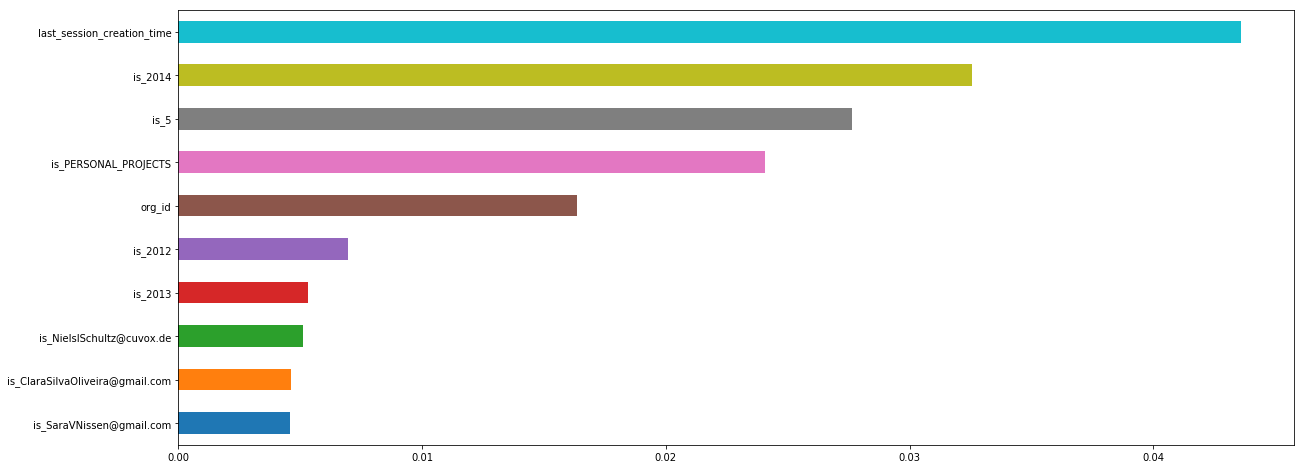

In [29]:
# feature importance
feature_importance = pd.Series(index = train_x.columns, data = np.abs(rf.feature_importances_))
selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    selected_features,(1-selected_features/len(feature_importance))*100))
feature_importance.sort_values().tail(10).plot(kind = 'barh', figsize = (20,8))

The result showed that last_session_creation_time is the most importnat features. While there are some features such as year, certain users, and persona_project are also important features. 

Majority of the users are non-adpoted users, more research should be done to study how could the startegy be to increase more adopted users.